<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-datasets" data-toc-modified-id="Load-datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load datasets</a></span></li><li><span><a href="#Figure-2---CysB-iModulons" data-toc-modified-id="Figure-2---CysB-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 2 - CysB iModulons</a></span><ul class="toc-item"><li><span><a href="#Get-CysB-cluster" data-toc-modified-id="Get-CysB-cluster-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get CysB cluster</a></span><ul class="toc-item"><li><span><a href="#Figure-out-which-I-modulons-from-RNAseq-1-can-combine-to-form-CysB-from-MA-3" data-toc-modified-id="Figure-out-which-I-modulons-from-RNAseq-1-can-combine-to-form-CysB-from-MA-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Figure out which I-modulons from RNAseq-1 can combine to form CysB from MA-3</a></span></li></ul></li></ul></li><li><span><a href="#Figure-2a---4x4-plot" data-toc-modified-id="Figure-2a---4x4-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 2a - 4x4 plot</a></span><ul class="toc-item"><li><span><a href="#Figure-2b---iModulon-summation" data-toc-modified-id="Figure-2b---iModulon-summation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Figure 2b - iModulon summation</a></span></li></ul></li></ul></div>

# Load datasets

In [1]:
import sys
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from itertools import combinations
sys.path.append('../../scripts/')
from core import *
from rbh import *

In [2]:
sns.set_style('ticks')
plt.style.use('custom')

In [3]:
datasets = sorted([x for x in os.listdir(os.path.join(DATA_DIR,'iModulons'))
            if '.' not in x])

# Remove combined
datasets = datasets[:-1]

In [4]:
# Thresholds were obtained from sensitivity analysis
cutoffs = {'MA-1': 550,
 'MA-2': 600,
 'MA-3': 350,
 'RNAseq-1': 700,
 'RNAseq-2': 300,
 'combined': 400}

In [5]:
def load(dataset):
    # Define directories
    ds_dir = os.path.join(DATA_DIR,'iModulons',dataset)
    
    # Define files
    X_file = os.path.join(DATA_DIR,'processed_data',dataset+'.csv')
    M_file = os.path.join(ds_dir,'M.csv')
    A_file = os.path.join(ds_dir,'A.csv')
    metadata_file = os.path.join(DATA_DIR,'metadata',dataset+'_metadata.csv')
    
    return IcaData(M_file,A_file,X_file,metadata_file,cutoffs[dataset])

In [6]:
# Load datasets
objs = {}
for ds in tqdm(datasets):
    objs[ds] = load(ds)

In [7]:
DF_categories = pd.read_csv(os.path.join(DATA_DIR,'iModulons','categories_curated.csv'),index_col=0)
DF_categories = DF_categories[DF_categories.dataset != 'combined']

In [8]:
[objs[ds].X.shape[1] for ds in datasets]

[260, 124, 56, 278, 84]

Text(0, 0.5, 'Number of Expression Profiles')

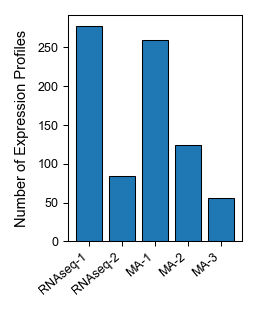

In [9]:
fig,ax = plt.subplots(figsize=(1.5,2))
plt.bar(range(5),[278,84,260,124,56],color='tab:blue')
plt.xticks(range(5),['RNAseq-1','RNAseq-2','MA-1','MA-2','MA-3'],rotation=40,ha='right')
plt.ylabel('Number of Expression Profiles') 

# Figure 2 - CysB iModulons

## Get CysB cluster

In [10]:
cysB_imods = {'RNAseq-1':46,'RNAseq-2':25,'MA-1':12,'MA-2':6,'MA-3':6}

In [11]:
cysB_genes = trn[trn.TF == 'cysB'].gene_id.tolist()

### Figure out which I-modulons from RNAseq-1 can combine to form CysB from MA-3

In [12]:
cysb_list = [set(objs[ds].show_enriched(k).index.tolist()) for ds,k in cysB_imods.items()]
print('MA-3 contains this percent of other i-modulons:',
      np.mean([len(cysb_list[2] & cysb_list[i])/len(cysb_list[i]) for i in [0,1,3,4]]))

MA-3 contains this percent of other i-modulons: 0.5392454515919428


In [13]:
ma3_cysb_genes = set(objs['MA-3'].show_enriched(6).index.tolist())

In [14]:
# Find the 10 components in RNAseq-1 that correlate highest with MA-3
X = objs['RNAseq-1'].M
y = objs['MA-3'].M[6]

corrs = np.array([abs(stats.pearsonr(X[k],y)[0]) for k in objs['RNAseq-1'].M.columns])
rnaseq1_mods = np.argsort(corrs)[-10:]

In [15]:
rnaseq1_mods

array([58,  3, 78, 77, 73, 87, 17, 24, 54, 46])

In [16]:
# Get associated regulators for these i-modulons
ma3_regs = [DF_categories.loc['RNAseq-1_'+str(k)].description for k in rnaseq1_mods]
ma3_regs

['glpR',
 'cellular response to nutrient levels',
 nan,
 'trpR',
 'metJ',
 'leu-tRNA',
 'argR',
 'lrp',
 'TPP',
 'cysB']

# Figure 2a - 4x4 plot

In [17]:
cysB_genes = trn[trn.TF == 'cysB'].gene_id.tolist()
reg_genes = set(trn[trn.TF.isin(ma3_regs)].gene_id.tolist()) - set(cysB_genes)
# reg_genes = set.union(*[set(objs['RNAseq-1'].show_enriched(k).index) for k in rnaseq1_mods[:-1]]) # remove cysB
other_genes = set(objs['RNAseq-1'].M.index) - set(cysB_genes) - set(reg_genes)

In [18]:
print('MA-3 genes absent from all other i-modulons:',
      len(cysb_list[4] - cysb_list[0] - cysb_list[1] - cysb_list[3] - cysb_list[2]))

MA-3 genes absent from all other i-modulons: 59


In [19]:
from functools import reduce
cysB_all_genes = reduce(set.intersection,cysb_list)

In [20]:
print('Genes in all CysB i-modulons',len(cysB_all_genes))
print('Genes not known to be regulated by CysB:')
print([num2name[x] for x in cysB_all_genes - set(cysB_genes)])

Genes in all CysB i-modulons 16
Genes not known to be regulated by CysB:
['yeeD', 'yeeE', 'gsiA']


In [21]:
for x in combinations(cysB_imods.items(),2):
    print(x)

(('RNAseq-1', 46), ('RNAseq-2', 25))
(('RNAseq-1', 46), ('MA-1', 12))
(('RNAseq-1', 46), ('MA-2', 6))
(('RNAseq-1', 46), ('MA-3', 6))
(('RNAseq-2', 25), ('MA-1', 12))
(('RNAseq-2', 25), ('MA-2', 6))
(('RNAseq-2', 25), ('MA-3', 6))
(('MA-1', 12), ('MA-2', 6))
(('MA-1', 12), ('MA-3', 6))
(('MA-2', 6), ('MA-3', 6))


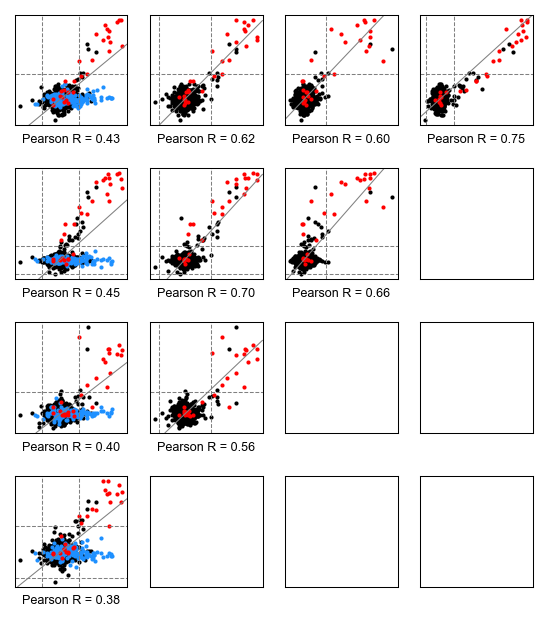

In [22]:
s = 4
fig,ax = plt.subplots(4,4,figsize=(3.75,4.25))
for (i,(ds1,k1)),(j,(ds2,k2)) in combinations(enumerate(cysB_imods.items()),2):
    
    j = 5-j-1
    
    # If dataset is in MA-3, plot genes in other regulons
    if ds1 == 'MA-3' or ds2 == 'MA-3':
        ax[i,j].scatter(objs[ds2].M.loc[other_genes,k2],objs[ds1].M.loc[other_genes,k1],
                        s=s,color='k',linewidth=0)
        ax[i,j].scatter(objs[ds2].M.loc[reg_genes,k2],objs[ds1].M.loc[reg_genes,k1],
                        s=s,color='dodgerblue',linewidth=0)
    else:
        ax[i,j].scatter(objs[ds2].M.loc[reg_genes|other_genes,k2],
                        objs[ds1].M.loc[reg_genes|other_genes,k1],
                        s=s,color='k',linewidth=0)
    ax[i,j].scatter(objs[ds2].M.loc[cysB_genes,k2],objs[ds1].M.loc[cysB_genes,k1],
                    s=s,color='r',linewidth=0)
    
    # Plot thresholds and 45 degree line
    xmin,xmax = ax[i,j].get_xlim()
    ymin,ymax = ax[i,j].get_ylim()
    allmin = max(xmin,ymin)
    allmax = min(xmax,ymax)
    
    ax[i,j].plot([allmin,allmax],[allmin,allmax],color='grey',linewidth=.5)
    
    ax[i,j].vlines([-objs[ds2].thresholds[k2],objs[ds2].thresholds[k2]],ymin,ymax,
                   linewidths=.5,color='gray',linestyle='dashed')
    ax[i,j].hlines([-objs[ds1].thresholds[k1],objs[ds1].thresholds[k1]],xmin,xmax,
                   linewidths=.5,color='gray',linestyle='dashed')
    
    # Tick params
    ax[i,j].set_xlim([xmin,xmax])
    ax[i,j].set_ylim([ymin,ymax])
    ax[i,j].tick_params(bottom=False,labelbottom=False,left=False,labelleft=False)    
    ax[i,j].set_xlabel('Pearson R = {:.2f}'.format(stats.pearsonr(objs[ds1].M[k1],objs[ds2].M[k2])[0]),
                       fontsize=6)

for row in ax:
    for panel in row:
        panel.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False)
    
    
plt.tight_layout()

In [23]:
set1 = set(objs['RNAseq-1'].show_enriched(46).index)
set2 = set(objs['RNAseq-2'].show_enriched(25).index)
set3 = set(objs['MA-1'].show_enriched(12).index)
set4 = set(objs['MA-2'].show_enriched(6).index)
set5 = set(objs['MA-3'].show_enriched(6).index)

In [24]:
from itertools import combinations_with_replacement

In [25]:
overlaps = [len(s1 & s2) / len(s1) for s1,s2 in combinations_with_replacement([set1,set2,set3,set4,set5],2)]
np.mean(overlaps)

0.8728908382066277

## Figure 2b - iModulon summation

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
X = objs['RNAseq-1'].M[rnaseq1_mods]
y = objs['MA-3'].M[6]
lm = LinearRegression(fit_intercept=False)
lm.fit(X,y)

LinearRegression(fit_intercept=False)

In [28]:
yprime = pd.Series(lm.predict(X),index=y.index)

In [29]:
desc = [DF_categories.loc['RNAseq-1_'+str(k)]['description'] for k in X.columns]

In [33]:
pd.DataFrame([['RNAseq-1_'+str(k) for k in X.columns],desc,list(lm.coef_)],index=['I-modulon','Description',
                                                                                  'Linear Regression Coefficient']).T

,I-modulon,Description,Linear Regression Coefficient
0,RNAseq-1_58,glpR,0.106558
1,RNAseq-1_3,cellular response to nutrient levels,-0.109289
2,RNAseq-1_78,NaN,-0.137547
3,RNAseq-1_77,trpR,0.15401
4,RNAseq-1_73,metJ,0.151118
5,RNAseq-1_87,leu-tRNA,0.190403
6,RNAseq-1_17,argR,0.202501
7,RNAseq-1_24,lrp,-0.203731
8,RNAseq-1_54,TPP,0.290562
9,RNAseq-1_46,cysB,0.436685


In [31]:
stats.pearsonr(y,yprime)

(0.6861739910368674, 0.0)

Text(0.5, 0, 'MA-3 CysB I-modulon')

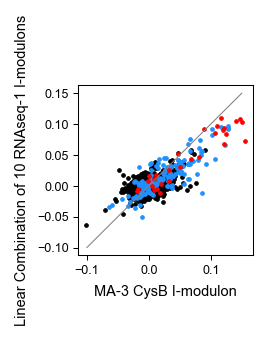

In [32]:
fig,ax = plt.subplots(figsize=(1.5,1.5))

label_text = '$R^2$ = {:.2f}'.format(lm.score(X,y))


ax.scatter(y.loc[other_genes],yprime.loc[other_genes],s=3,color='black')
ax.scatter(y.loc[reg_genes],yprime.loc[reg_genes],s=3,color='dodgerblue')
ax.scatter(y.loc[cysB_genes],yprime.loc[cysB_genes],s=3,color='red')

ax.plot([-.1,.15],[-.1,.15],color='grey',linewidth=0.5)
ax.axis('equal');
#ax.legend(loc=4)
ax.set_ylabel('Linear Combination of 10 RNAseq-1 I-modulons')
ax.set_xlabel('MA-3 CysB I-modulon')